In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter
from tqdm import tqdm

In [2]:
def load_frames_from_video_file(
    path: Path, in_frame: int = 0, out_frame: int = -1
) -> np.ndarray:
    """Load frames from video file."""
    assert in_frame >= 0
    assert in_frame < out_frame or out_frame == -1

    video_capture = cv2.VideoCapture(str(path))
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, in_frame)
    frames = []
    done = False
    while not done:
        success, frame_bgr = video_capture.read()
        if not success:
            break
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        if out_frame > 0 and in_frame + len(frames) >= out_frame:
            break
    video_capture.release()

    return np.array(frames)

In [3]:
in_frame = 1
out_frame = 40

video_dir = Path("/Volumes/PortableSSD/FRV3F009")
video_file_dusty = video_dir / "FRV3F009 Denoised.mov"
video_file_clean = video_dir / "FRV3F009 Final.mov"

dusty_frames = load_frames_from_video_file(video_file_dusty, in_frame, out_frame)
clean_frames = load_frames_from_video_file(
    video_file_clean, in_frame - 1, out_frame - 1
)


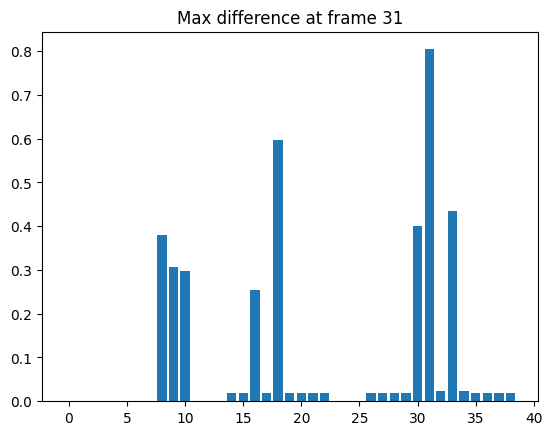

In [4]:
diffs = dusty_frames / 255 - clean_frames / 255
abs_diffs = np.abs(diffs)
frame_max_diffs = np.max(abs_diffs, axis=(1, 2, 3))

plt.bar(np.arange(len(clean_frames)), frame_max_diffs)
plt.title(f"Max difference at frame {np.argmax(frame_max_diffs)}")
plt.show()

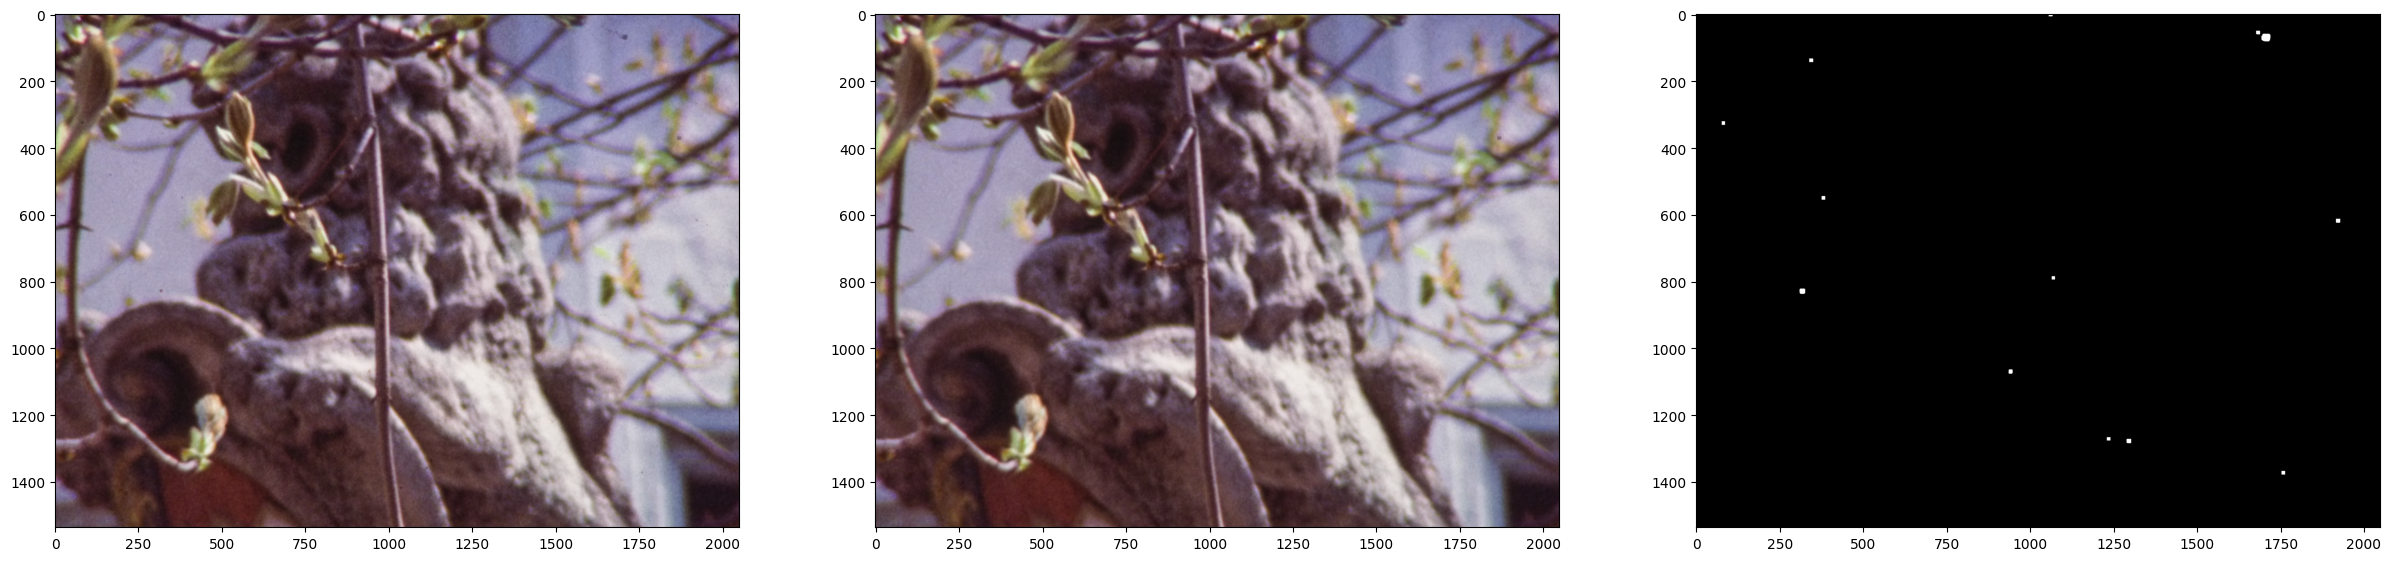

In [5]:
frame_index = 10
threshold = 0.13

diff_frame = clean_frames[frame_index] / 255 - dusty_frames[frame_index] / 255
diff_frame = np.abs(diff_frame)
diff_frame = np.max(diff_frame, axis=2)
diff_frame[diff_frame < threshold] = 0
diff_frame[diff_frame >= threshold] = 1
diff_frame = minimum_filter(diff_frame, size=2)
diff_frame = maximum_filter(diff_frame, size=10)

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(dusty_frames[frame_index])
plt.subplot(1, 3, 2)
plt.imshow(clean_frames[frame_index])
plt.subplot(1, 3, 3)
plt.imshow(diff_frame, vmin=0, cmap="gray")
plt.show()

In [6]:
def compute_frame_differences(
    video_file_dusty: Path, video_file_clean: Path, in_frame: int, clean_offset: int
) -> np.ndarray:
    dusty_capture = cv2.VideoCapture(str(video_file_dusty))
    clean_capture = cv2.VideoCapture(str(video_file_clean))

    if clean_offset < 0:
        in_frame += -clean_offset

    dusty_capture.set(cv2.CAP_PROP_POS_FRAMES, in_frame)
    clean_capture.set(cv2.CAP_PROP_POS_FRAMES, in_frame + clean_offset)

    frame_diffs = []
    done = False
    pbar = tqdm()
    while not done:
        dusty_success, dusty_frame = dusty_capture.read()
        clean_success, clean_frame = clean_capture.read()

        if not dusty_success or not clean_success:
            break  # Stop if either video at its end

        diff = dusty_frame / 255 - clean_frame / 255
        abs_diff = np.abs(diff)
        frame_max_diff = np.max(abs_diff)

        frame_diffs.append(frame_max_diff)

        pbar.update(n=1)

    return np.array(frame_diffs)

In [7]:
frame_diffs = compute_frame_differences(
    video_file_dusty, video_file_clean, in_frame=0, clean_offset=-1
)

3633it [04:28, 13.54it/s]


In [9]:
dusty_frame_idxs = np.argwhere(frame_diffs > 0.1).squeeze()
clean_frame_idxs = np.argwhere(frame_diffs <= 0.1).squeeze()

print(f"Number of dusty frames: {len(dusty_frame_idxs)}")
print(f"Number of clean frames: {len(clean_frame_idxs)}")

Number of dusty frames: 674
Number of clean frames: 2959


In [13]:
# Select at random as many clean frames as there are dusty frames
selected_clean_frame_idxs = np.random.choice(
    clean_frame_idxs, len(dusty_frame_idxs), replace=False
)

print(
    f"Number of clean randomly selected clean frames: {len(selected_clean_frame_idxs)}"
)


Number of clean randomly selected clean frames: 674


In [15]:
dataset_frame_idxs = np.concatenate([dusty_frame_idxs, selected_clean_frame_idxs])

print(f"Found {len(dataset_frame_idxs)} frames in total to use for training")


Found 1348 frames in total to use for training


In [60]:
def generate_dust_and_scratch_masks(
    dusty_video_file: Path,
    clean_video_file,
    in_frame: int,
    clean_offset: int,
    output_dir: Path,
    frame_idxs: np.ndarray,
) -> None:
    dusty_capture = cv2.VideoCapture(str(dusty_video_file))
    clean_capture = cv2.VideoCapture(str(clean_video_file))

    if clean_offset < 0:
        in_frame += -clean_offset

    for i in tqdm(frame_idxs):
        dusty_capture.set(cv2.CAP_PROP_POS_FRAMES, i)
        clean_capture.set(cv2.CAP_PROP_POS_FRAMES, i + clean_offset)

        dusty_success, dusty_frame = dusty_capture.read()
        clean_success, clean_frame = clean_capture.read()

        mask_threshold = 0.13

        diff_frame = clean_frame / 255 - dusty_frame / 255
        diff_frame = np.abs(diff_frame)
        diff_frame = np.max(diff_frame, axis=2)
        diff_frame[diff_frame < mask_threshold] = 0
        diff_frame[diff_frame >= mask_threshold] = 1
        diff_frame = minimum_filter(diff_frame, size=2)
        diff_frame = maximum_filter(diff_frame, size=10)

        diff_frame_uint8 = (diff_frame * 255).astype(np.uint8)
        diff_frame_bgr = cv2.merge(
            [diff_frame_uint8, diff_frame_uint8, diff_frame_uint8]
        )

        cv2.imwrite(str(output_dir / "masks" / f"mask-{i:06d}.png"), diff_frame_bgr)

        cv2.imwrite(str(output_dir / "imgs" / f"img-{i:06d}.jpg"), dusty_frame)

In [61]:
generate_dust_and_scratch_masks(
    dusty_video_file=video_file_dusty,
    clean_video_file=video_file_clean,
    in_frame=0,
    clean_offset=-1,
    output_dir=Path("test_masks"),
    frame_idxs=dataset_frame_idxs,
)

100%|██████████| 1348/1348 [09:15<00:00,  2.43it/s]
